### Lorentizan Functions

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
from zipfile import ZipFile, ZIP_DEFLATED

In [73]:
peak_densities_all = ['small', 'medium', 'large', 'very_large']
peak_density = peak_densities_all[1]

In [74]:
np.random.seed(42) # for reproducibility
num_repetitions = 2000
num_xs = 11763
x = np.linspace(0, 10, num_xs)

signals = np.zeros((num_repetitions, len(x)))
func_params = []

In [75]:
all_peaks = []

In [76]:
binary_peaks = np.zeros((num_repetitions, num_xs))

In [77]:
import math

In [78]:

for i in range(num_repetitions):
    if peak_density == 'small':
        n_func = np.random.randint(5, 10)
    elif peak_density == 'medium':
        n_func = np.random.randint(10, 15)
    elif peak_density == 'large':
        n_func = np.random.randint(15, 25)
    else: n_func = np.random.randint(25, 40)
    
    signal = np.zeros(num_xs, )
    parameters = []
    peaks = []

    # min_d = 0.08 # shouldn't be a constant; consider the width of the peak that it's under
    used_means = []

    for _ in range(n_func):
        attempts = 0
        while True:
            a = np.random.uniform(1,8)
            b = np.random.uniform(0.05,0.1) # rule of thumb is 7 points per peak, maybe 5
            fwhm = 2 * b
            min_d = fwhm * 2

            if all(abs(a - m) >= min_d for m in used_means):
                used_means.append(a)
                break
            attempts += 1
            if attempts > 200: # avoid inf loop
                break

        amp = np.random.uniform(0.01, 1.00) # Vary amplitudes in the range of [0.01, 1.0]
        lor = (1 / math.pi) * (b / ((x - a)**2 + b**2)) * amp 

        signal += lor
        parameters.append((a, b))

        peak_index = np.argmax(lor)
        peaks.append(peak_index)

        trim_min, trim_max = (a - fwhm / 4, a + fwhm / 4)

        # Create a boolean mask where x_values are between trim_min and trim_max
        trim_mask = (x >= trim_min) & (x <= trim_max)

        add_ones = np.where(trim_mask == True)[0]
        binary_peaks[i][add_ones] = 1

    signals[i] = signal
    func_params.append(parameters)
    all_peaks.append(peaks)

    # make example figures of things in my workflow; going from 1 to 2 to more peaks

    # while loop will have another step


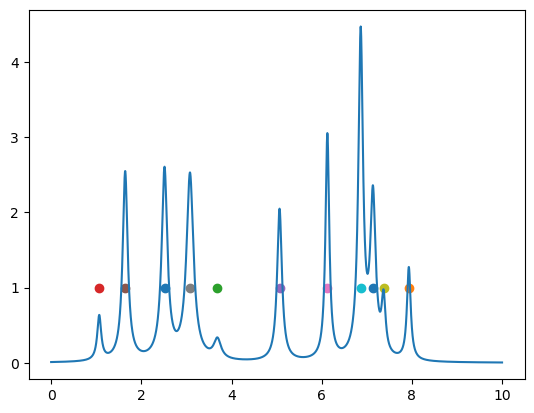

In [79]:
# adding
plt.figure()
i = 18
plt.plot(x, signals[i])
for j in range(len(all_peaks[i])):
    plt.scatter(x[all_peaks[i][j]], 1)

(2000, 11763)


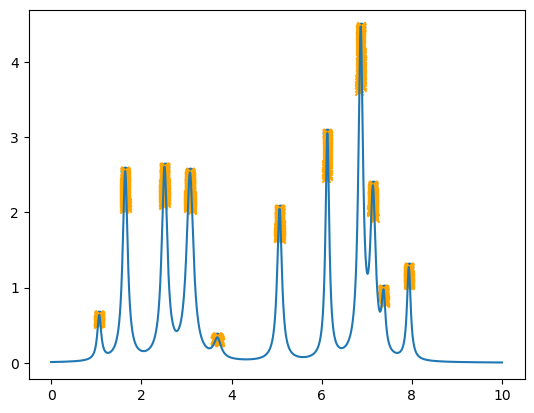

In [80]:
# Visualize labeled peaks

plt.figure()
i=18

print(binary_peaks.shape)

all_ones = np.where(binary_peaks[i] > 0)[0]
all_ones.shape

plt.plot(x, signals[i])
plt.scatter(x[all_peaks[i]], signals[i][all_peaks[i]])

plt.scatter(x[all_ones], signals[i][all_ones], marker='x', color='orange')

plt.show()

In [81]:
all_peaks[0]

[np.int64(9004),
 np.int64(2461),
 np.int64(8308),
 np.int64(1346),
 np.int64(2924),
 np.int64(3681),
 np.int64(4193),
 np.int64(6054),
 np.int64(7832),
 np.int64(6810),
 np.int64(5253),
 np.int64(5677),
 np.int64(1786)]

In [82]:
np.argmax(signals[0], axis=0)

np.int64(5253)

In [83]:
def add_noise_by_percentage(signal, noise_percentage):
        """
        Add random noise to a NumPy array based on a percentage of the maximum signal value.

        Parameters:
            signal (numpy.ndarray): The original signal array.
            noise_percentage (float): Percentage of the maximum signal value to use as noise.

        Returns:
            noisy_signal (numpy.ndarray): The signal array with added noise.
        """
        # Find the maximum value in the signal
        max_value = np.max(np.abs(signal))

        # Calculate the noise standard deviation as a percentage of the max signal value
        noise_std = (noise_percentage / 100) * max_value

        # Generate random Gaussian noise with zero mean and calculated standard deviation
        noise = np.random.normal(0.005, noise_std, signal.shape)

        # Add the noise to the original signal
        noisy_signal = signal + noise

        return noisy_signal
noise_level = 0.2
noisy_signal = add_noise_by_percentage(signals, noise_level)

In [84]:
ds = xr.Dataset(
    {
        "Intensities": (["pattern", "x"], noisy_signal),
        "BinaryArr": (["pattern", "x"], binary_peaks)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": np.linspace(1, 10, x.shape[0])
    },
    attrs={
        "description": "Simulated Lorentzian signals with labeled peaks, padded with 1s along FWHM",
        "min_d_rule": "Minimum distance between peaks = fwhm",
        "fwhm_definition": "FWHM = 2 * HWHM (b); used in min_d calculation",
        "note": f"Each pattern contains a {peak_density} number of Lorentzian peaks. Used_means enforces peak spacing.",
        "params": "a=np.random.uniform(1,8), b=np.random.uniform(0.05,0.1) with seed=42",
        "noise": f"True, 0.{noise_level}%",
        "number": f"{num_repetitions} patterns"
    }
)

In [85]:
np.linspace(1, 10, x.shape[0])

array([ 1.        ,  1.00076518,  1.00153035, ...,  9.99846965,
        9.99923482, 10.        ])

In [86]:
intensities = ds["Intensities"].values
binary = ds["BinaryArr"].values

(2000, 11763)


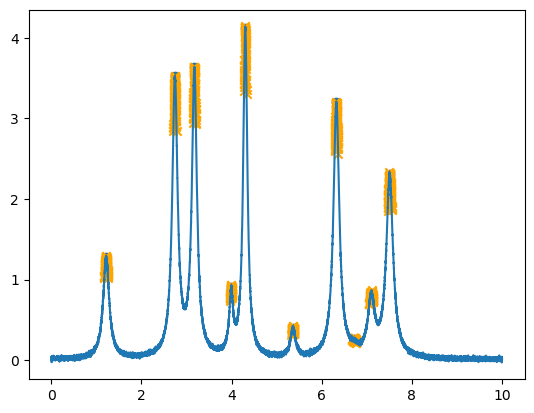

In [87]:
# Check that there is noise
plt.figure()

i=1
print(binary_peaks.shape)

all_ones = np.where(binary_peaks[i] > 0)[0]
all_ones.shape

plt.plot(x, intensities[i])
plt.scatter(x[all_peaks[i]], intensities[i][all_peaks[i]])

plt.scatter(x[all_ones], intensities[i][all_ones], marker='x', color='orange')

plt.show()


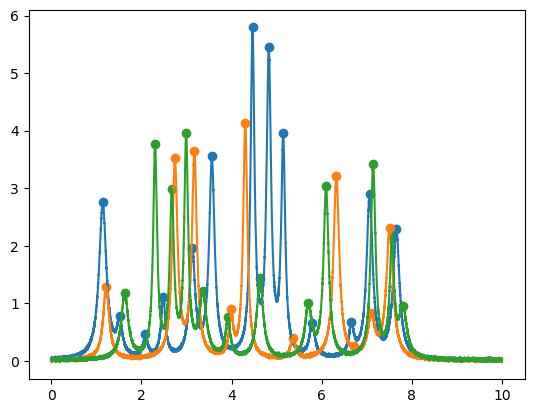

In [88]:
plt.figure()
for i in range(3):
    plt.plot(x, intensities[i])
    plt.scatter(x[all_peaks[i]], intensities[i][all_peaks[i]])
plt.show()

In [89]:
path = '../saved_data/'
file = f'lorentzian_functions_{peak_density}_var_amps_noisy_11763.nc'

ds.to_netcdf(os.path.join(path, file))
with ZipFile(os.path.join(path,file.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file), arcname=file)
